In [ ]:
!pip install patool

     |████████████████████████████████| 81kB 5.4MB/s 


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers import Dense, Activation, Dropout, Bidirectional
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import keras
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
import shutil
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
import sys
import ssl
import urllib.request
import certifi
import patoolib
from sklearn.metrics import classification_report
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
URL_LINK = 'https://www.crcv.ucf.edu/data/UCF101/UCF101.rar'
BATCH_SIZE = 64

In [ ]:
!ls "/content/resnet50/processedData"

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
currentPath = os.getcwd()
basePath = os.path.join(currentPath, "resnet50")
featurePath = os.path.join(basePath, "feature")
arcPath = os.path.join(basePath, "lstm.json")
modelPath = os.path.join(basePath, "model.h5")
configPath = os.path.join(basePath, "config")
dataBasePath = os.path.join(basePath, "data")

processedDataPath = os.path.join(basePath, "processedData")
paths = []
paths.append(basePath)
paths.append(featurePath)
paths.append(configPath)
paths.append(dataBasePath)
paths.append(processedDataPath)
print(processedDataPath)
for path in paths:
    if not os.path.isdir(path):
        os.mkdir(path)


/content/resnet50/processedData


In [ ]:
def reporthook(block_num, block_size, total_size):
    read_so_far = block_num * block_size
    if total_size > 0:
        percent = read_so_far * 1e2 / total_size
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(total_size)), read_so_far, total_size)
        sys.stderr.write(s)
        if read_so_far >= total_size:  # near the end
            sys.stderr.write("\n")
    else:  # total size is unknown
        sys.stderr.write("read %d\n" % (read_so_far,))


In [ ]:
ucf_rar = os.path.join(dataBasePath, "UCF101.rar")
if not os.path.exists(ucf_rar):
    print("ucf file does not exist, downloading")
    ssl._create_default_https_context = ssl._create_unverified_context
    urllib.request.urlretrieve(url=URL_LINK, filename = ucf_rar, reporthook=reporthook)
print("now we unzip ucf file")
patoolib.extract_archive(ucf_rar, outdir=dataBasePath)

ucf file does not exist, downloading


100.0% 6932979712 / 6932971618


now we unzip ucf file
patool: Extracting /content/resnet50/data/UCF101.rar ...
patool: running /usr/bin/unrar x -- /content/resnet50/data/UCF101.rar
patool:     with cwd='/content/resnet50/data'
patool: ... /content/resnet50/data/UCF101.rar extracted to `/content/resnet50/data'.


'/content/resnet50/data'

In [ ]:
def extractFeatures(model, video, outputPath):
    if os.path.exists(outputPath):
        return np.load(outputPath)
    count = 0
    vidcap = cv2.VideoCapture(video)
    success, image = vidcap.read()
    features = []
    while success:
        success, image = vidcap.read()
        if success:
            img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            input = img_to_array(img)
            input = np.expand_dims(input, axis = 0)
            input = preprocess_input(input)
            feature = model.predict(input).ravel()
            features.append(feature)
            count += 1
    unscaled_features = np.array(features)
    np.save(outputPath, unscaled_features)
    return 

In [ ]:
import keras.backend as K
import gc
def scanExtractFeatrues(dataPath, outputPath):
    x_samples = []
    y_samples = []
    dirCount = 0
    model = None
    for f in os.listdir(dataPath):
        folderPath = os.path.join(dataPath, f)
        if not os.path.exists(featurePath):
            outputPath = os.path.join(featurePath, f)
            os.mkdir(outputPath)
        dirCount += 1
        print("now working on ", f, " and start cleaning keras")
        if model is not None:
            del model
            K.clear_session()
            g = gc.collect()            
            print("Done Cleaning GPU")
        model = VGG16(include_top = False, weights = "imagenet")
        model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])            
        try:
            for video in os.listdir(folderPath):                
                videoPath = os.path.join(folderPath, video)
                outputFile = outputPath + os.path.sep + video.split(".")[0] + ".npy"
                extractFeatures(model, videoPath, outputFile)
        except:
            print("something is wrong with ", f, " skipping it")
    return 

In [ ]:
def generate_batch(x_samples, y_samples):
    num_batches = len(x_samples) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            yield np.array(x_samples[start:end]), y_samples[start:end]

In [ ]:
# # this is the dynamic learning rate function
# def learningRate(epoch):
#     if epoch < 10:
#         return 0.001
#     else:
#         return 0.001 * np.exp(0.1 * (10 - epoch))
# this is the dynamic learning rate function
def learningRate(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

In [ ]:
class CustomizeGenerator(keras.utils.Sequence):
    def __init__(self, filenames, labels, batchSize, filePath):
        self.filenames = filenames
        self.labels = labels
        self.batchSize = batchSize
        self.filePath = filePath
    def __len__(self):
        return (np.ceil(len(self.filenames) / float(self.batchSize))).astype(np.int)
    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batchSize : (idx + 1) * self.batchSize]
        batch_y = self.labels[idx * self.batchSize : (idx + 1) * self.batchSize]
        return np.array([np.load(os.path.join(self.filePath, name)) for name in batch_x]), np.array(batch_y)

In [ ]:
# first we build out Resnet 50 model without top layer

class resnet50BLSTMModel(object):
    def __init__(self):
        self.num_input_tokens = None
        self.nb_classes = None
        self.labels = None
        self.labels_idx2word = None
        self.model = None
        self.expected_frames = None
        self.config = None
    
    def biLSTM(self):
        model = Sequential()
        model.add(Bidirectional(LSTM(512, input_shape=(None, self.num_input_tokens), 
                                     return_sequences=True
                                     )))
        model.add(Bidirectional(LSTM(10)))
        model.add(Dense(512, activation="relu"))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes))
        model.add(Activation("softmax"))
        model.compile(loss="categorical_crossentropy", optimizer = "rmsprop", metrics=['accuracy'])
        return model

    def processData(self, inputPath, outputPath):
        max_frames = 0
        counter = 0

        print("now we process the data")
        frame_list = []
        for f in os.listdir(featurePath):
            samplePath = os.path.join(featurePath, f)
            sample = np.load(samplePath)
            if self.num_input_tokens == None:
                self.num_input_tokens = sample.shape[1]
            frames = sample.shape[0]
            frame_list.append(frames)
            max_frames = max(frames, max_frames)
            self.expected_frames = int(np.mean(frame_list))
        print("len of frame_list: ", len(frame_list))
        print("max frames: ", max_frames)
        print("expected frames: ", self.expected_frames)
        for f in os.listdir(featurePath):            
            samplePath = os.path.join(featurePath, f)
            sample = np.load(samplePath)
            frames = sample.shape[0]
            if frames > self.expected_frames:
                sample = sample[0:self.expected_frames, :]
            elif frames < self.expected_frames:
                temp = np.zeros(shape=(self.expected_frames, sample.shape[1]))
                temp[0: frames, :] = sample
                sample = temp
            outputFilePath = os.path.join(outputPath, f)
            counter += 1
            os.remove(samplePath)
            np.save(outputFilePath, sample)
        print("done processing data, with a total of ", counter , " files")
        return
    def printLabel(self):
      print(self.labels)
      return
    
    def fit(self, inputPath, modelPath, testSize = 0.25, randomState = 52):
        x_samples = []
        y_samples = []
        self.labels = dict()
        for file in os.listdir(inputPath):
            x_samples.append(file)
            y_samples.append(file.split(".")[0].split("_")[1])
        for y in y_samples:
            if y not in self.labels:
                self.labels[y] = len(self.labels)
        for i in range(len(y_samples)):
            y_samples[i] = self.labels[y_samples[i]]
        self.nb_classes = len(self.labels)
        y_samples = np_utils.to_categorical(y_samples, self.nb_classes)
        config = dict()
        print("labels")
        print(self.labels)
        config["labels"] = self.labels
        config["nb_classes"] = self.nb_classes
        config["num_input_tokens"] = self.num_input_tokens
        config["expected_frames"] = self.expected_frames
        print(config)

        self.config = config
        np.save("/content/config.npy", config)
        try:
          np.save("/content/drive/MyDrive/Colab Notebooks/UCF101/config.npy", config)
        except:
          print("ERR: cannot save config")
        BiLSTM = self.biLSTM()
        open(arcPath, "w").write(BiLSTM.to_json())
        xTrain, xTest, yTrain, yTest = train_test_split(x_samples, y_samples, test_size = 0.2, random_state = 52)
        batchSize = 32
        xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size = 0.2, random_state = 42)
        trainingGenerator = CustomizeGenerator(xTrain, yTrain, batchSize, inputPath)
        valGenerator = CustomizeGenerator(xVal, yVal, batchSize, inputPath)
        testGenerator = CustomizeGenerator(xTest, yTest, batchSize, inputPath)        

        checkpoint = ModelCheckpoint(filepath=modelPath, save_best_only = True)
        history = BiLSTM.fit(x=trainingGenerator, epochs=100, 
                            steps_per_epoch = int(len(xTrain) // batchSize),
                            verbose = 1,
                            validation_data = valGenerator,
                            validation_steps = int(len(xVal) // batchSize),
                            callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience = 5), callbacks.LearningRateScheduler(learningRate)],
                            )
        
        BiLSTM.save(modelPath)
        try:
          BiLSTM.save("/content/drive/MyDrive/Colab Notebooks/UCF101/blstmModel_resnet50.h5")
        except:
          print("erre saving model")
        print("Evaluating network")
        results = BiLSTM.evaluate_generator(testGenerator)
        print("test loss, test acc: ", results)
        return BiLSTM, history 
        




In [ ]:
classifier = resnet50BLSTMModel()
dataPath = os.path.join(dataBasePath, "UCF-101")
scanExtractFeatrues(dataPath, featurePath)
print("done extracting, and now we process the data")
if os.path.isdir(dataBasePath):
  shutil. rmtree(dataBasePath) # delete the original content to free space from disk
classifier.processData(featurePath, processedDataPath)
print("done processing. now we train")
model, history = classifier.fit(processedDataPath, modelPath, testSize=0.25, randomState=52)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

now working on  MoppingFloor  and start cleaning keras
58892288/58889256 [==============================] - 0s 0us/step
now working on  BrushingTeeth  and start cleaning keras
Done Cleaning GPU
now working on  PoleVault  and start cleaning keras
Done Cleaning GPU
now working on  StillRings  and start cleaning keras
Done Cleaning GPU
now working on  YoYo  and start cleaning keras
Done Cleaning GPU
now working on  SkateBoarding  and start cleaning keras
Done Cleaning GPU
now working on  PlayingCello  and start cleaning keras
Done Cleaning GPU
now working on  PullUps  and start cleaning keras
Done Cleaning GPU
now working on  BlowDryHair  and start cleaning keras
Done Cleaning GPU
now working on  Knitting  and start cleaning keras
Done Cleaning GPU
now working on  Shotput  and start cleaning keras
Done Cleaning GPU
now working on  Punch  and start cleaning keras
Done Cleaning GPU
now working on  HighJump  and start cleaning keras
Done Cleaning GPU
now working on  PlayingSitar  and start c

ValueError: ignored

In [ ]:
from google.colab import files
files.download("config.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done extracting, and now we process the data
done processing. now we train
labels
{'WallPushups': 0, 'MilitaryParade': 1, 'HorseRiding': 2, 'HorseRace': 3, 'SoccerJuggling': 4, 'BandMarching': 5, 'JumpingJack': 6, 'BlowDryHair': 7, 'PlayingCello': 8, 'Skiing': 9, 'VolleyballSpiking': 10, 'HeadMassage': 11, 'Typing': 12, 'CricketBowling': 13, 'Haircut': 14, 'SoccerPenalty': 15, 'Rowing': 16, 'Swing': 17, 'Basketball': 18, 'ThrowDiscus': 19, 'IceDancing': 20, 'FrisbeeCatch': 21, 'Skijet': 22, 'PullUps': 23, 'PlayingSitar': 24, 'SkyDiving': 25, 'Diving': 26, 'BasketballDunk': 27, 'CuttingInKitchen': 28, 'TennisSwing': 29, 'BoxingPunchingBag': 30, 'ShavingBeard': 31, 'GolfSwing': 32, 'RopeClimbing': 33, 'JumpRope': 34, 'BabyCrawling': 35, 'PlayingDhol': 36, 'TableTennisShot': 37, 'BlowingCandles': 38, 'Knitting': 39, 'ApplyEyeMakeup': 40, 'HulaHoop': 41, 'FrontCrawl': 42, 'Hammering': 43, 'Biking': 44, 'Archery': 45, 'SalsaSpin': 46, 'PushUps': 47, 'CliffDiving': 48, 'TrampolineJumping': 4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test loss, test acc:  [0.6190774440765381, 0.8858858942985535]


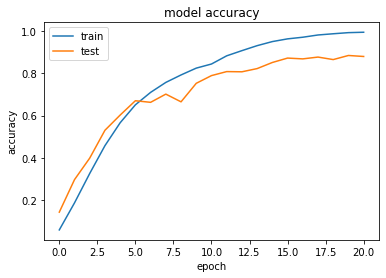

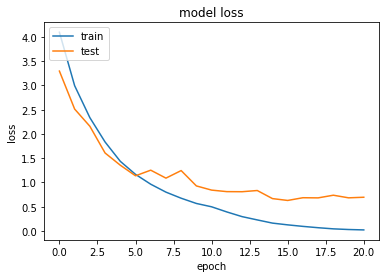

In [ ]:
classifier = resnet50BLSTMModel()
dataPath = os.path.join(dataBasePath, "UCF-101")
scanExtractFeatrues(dataPath, featurePath)
print("done extracting, and now we process the data")
if os.path.isdir(dataBasePath):
  shutil. rmtree(dataBasePath) # delete the original content to free space from disk
classifier.processData(featurePath, processedDataPath)
print("done processing. now we train")
model, history = classifier.fit(processedDataPath, modelPath, testSize=0.25, randomState=52)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!ls "/content/resnet50/"

config	config.npy  feature  lstm.json	model.h5  processedData


In [ ]:
from google.colab import files
files.download("/content/resnet50/model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp "/content/resnet50/model.h5" "/content/drive/MyDrive/Colab Notebooks/UCF101/newBiLSTM.h5"